In [1]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn as nn
from utils import utils
from models import cmgn, icgn, icnn, mmgn
from trainers import trainer_ot

plt.rcParams.update({
    "text.usetex": True,           
    "font.family": "serif", 
    "font.serif": ["Computer Modern Roman"],
})

# 2-Optimal Coupling

We generate two Gaussian distributions:

Source: A non-centered normal with covariance.
Target: A standard Gaussian.

In [3]:
# Set random seed
torch.manual_seed(42)

# we start by generating samples from a N(0, 1) and then apply the transformation Ax + µ to get the desired source distribution (using Cholesky decomposition)
mean_source = torch.tensor([2.0, 1.0])
cov_source = torch.tensor([[1.0, -0.8], [-0.8, 1.0]])

L = torch.linalg.cholesky(cov_source)
source_samples = torch.randn(1000, 2) @ L.T + mean_source
target_samples = torch.randn(1000, 2)

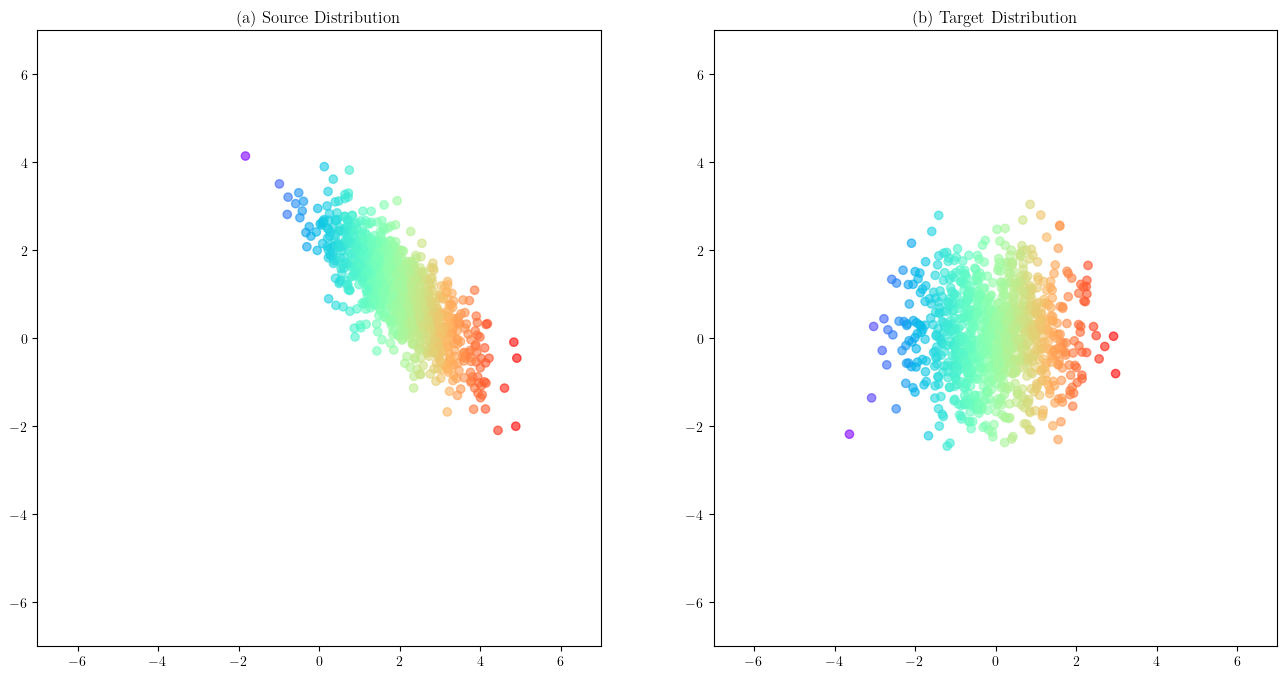

In [8]:
# Visualize both distributions
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.scatter(source_samples[:,0], source_samples[:,1], c=source_samples[:,0], cmap="rainbow", alpha=0.6)
plt.xlim(-7, 7)
plt.ylim(-7, 7)
plt.title("(a) Source Distribution")

plt.subplot(1,2,2)
plt.scatter(target_samples[:,0], target_samples[:,1], c=target_samples[:,0], cmap="rainbow", alpha=0.6)
plt.xlim(-7, 7)
plt.ylim(-7, 7)
plt.title("(b) Target Distribution")

plt.show()

In [4]:
# Training settings
epochs = 1000
lr = 1e-2
batch_size = 100
plot_interval = 100
input_dim = 2
output_dim = 2

In [ ]:

model_CMGN = cmgn.C_MGN(input_dim=input_dim, hidden_dim=2, num_layers=2, output_dim=output_dim)
optimizer = torch.optim.Adam(model_CMGN.parameters(), lr=lr)

In [13]:
trainer = trainer_ot.Trainer(model=model_CMGN, 
                  mean_source=mean_source, 
                  cov_source=cov_source, 
                  target_samples=target_samples, 
                  epochs=epochs, 
                  lr=lr, 
                  batch_size=batch_size, 
                  plot_interval=plot_interval, 
                  optimizer=optimizer, 
                  plot=False)

# Start training
costs_theorical, stored_costs, transformed_samples_history = trainer.train()


Epoch 0, Custom Loss: 10.1964
Epoch 100, Custom Loss: 3.5948
Epoch 200, Custom Loss: 2.9316
Epoch 300, Custom Loss: 2.5611
Epoch 400, Custom Loss: 2.4559
Epoch 500, Custom Loss: 2.4096
Epoch 600, Custom Loss: 2.4132
Epoch 700, Custom Loss: 2.4703
Epoch 800, Custom Loss: 2.3884
Epoch 900, Custom Loss: 2.3781


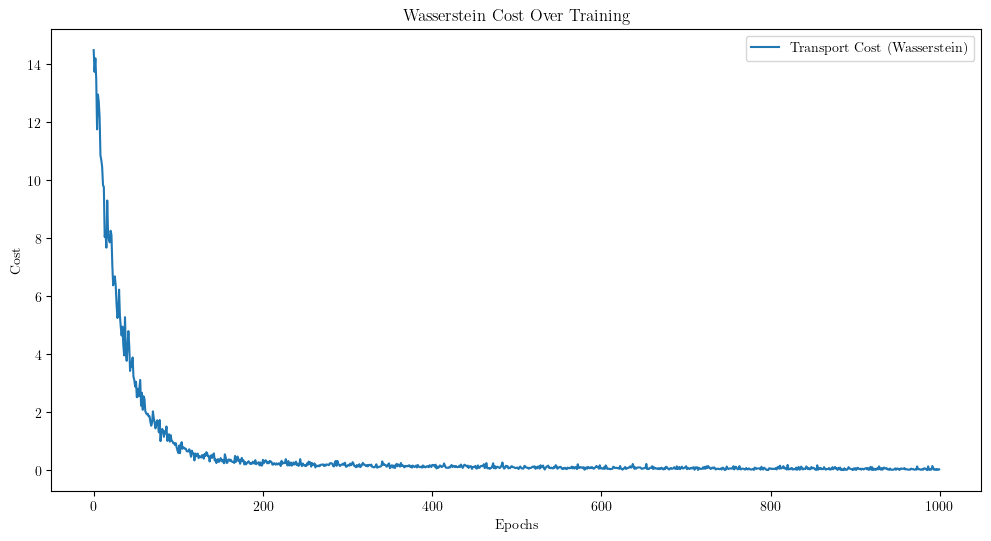

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(costs_theorical)), costs_theorical, label="Transport Cost (Wasserstein)")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Wasserstein Cost Over Training")
plt.legend()
plt.show()

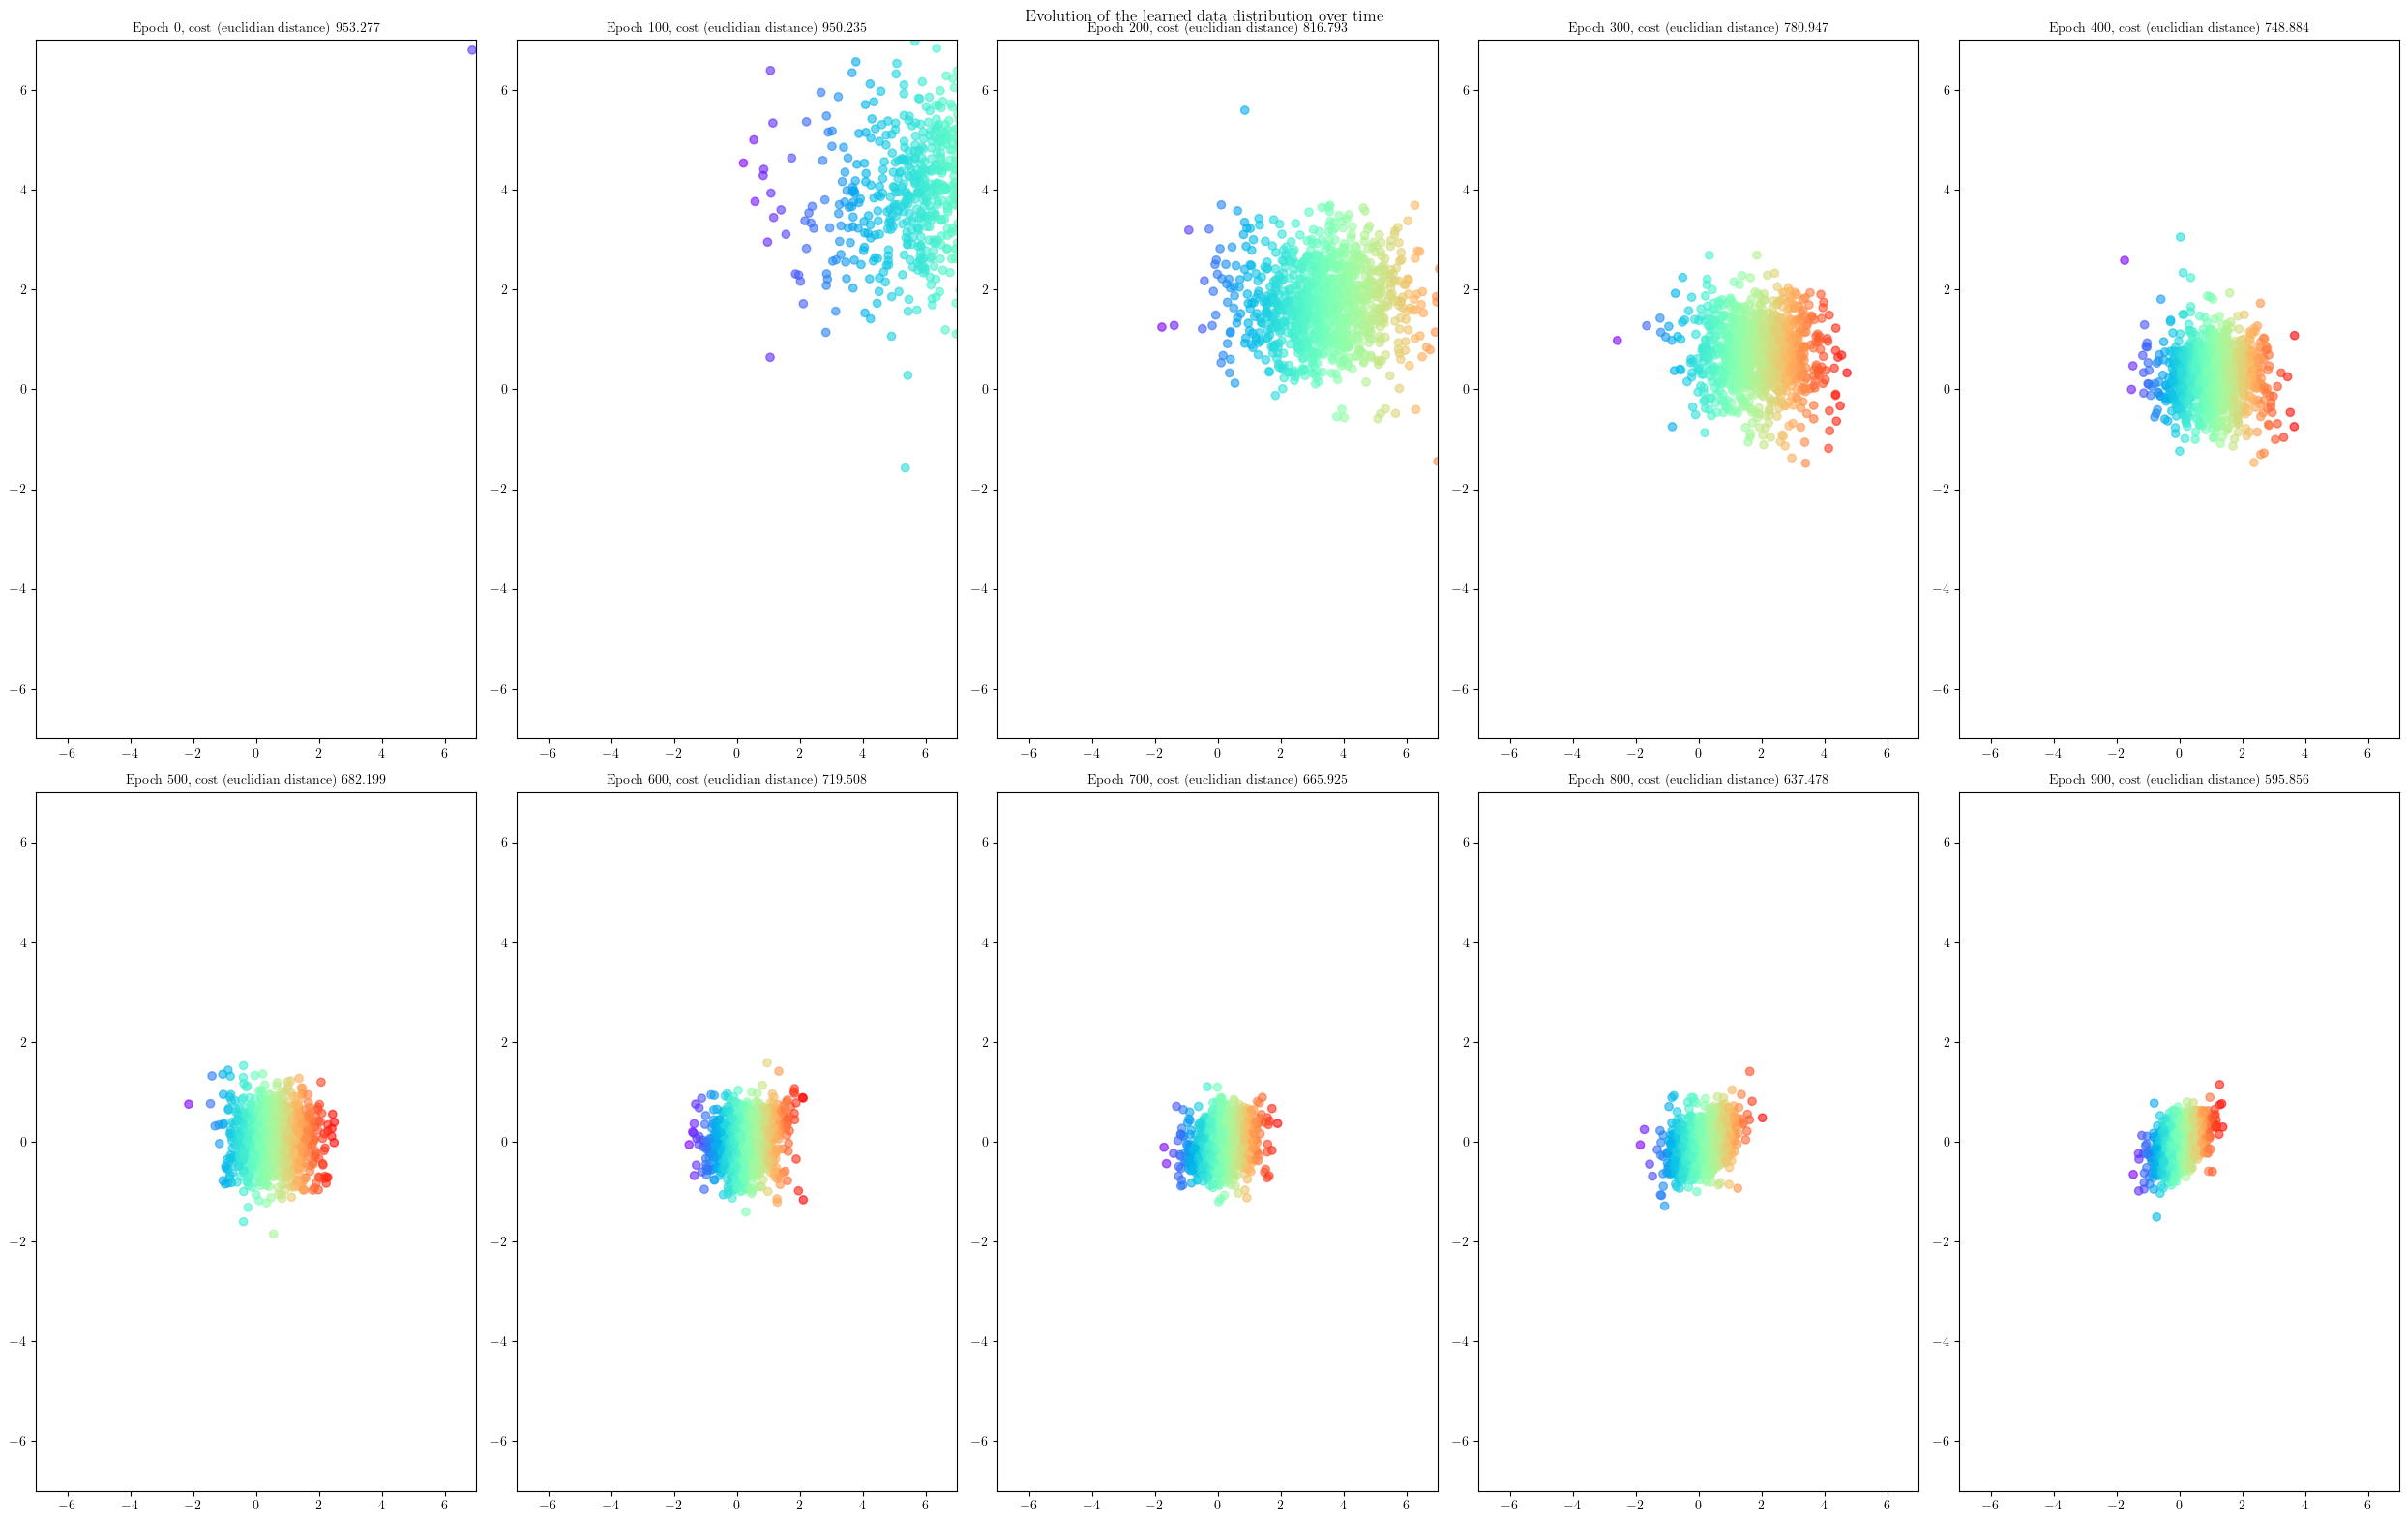

In [ ]:
# Plot transformed samples at different epochs in a grid layout
nbr_lines = epochs // 500 # i specifically work on 5 columns plotting
fig, axes = plt.subplots(nbr_lines, 5, figsize=(16, 8)) # figsize=(25, 16) 
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for i, (epoch, transformed_samples) in enumerate(transformed_samples_history.items()):
    row = i // 5 
    col = i % 5

    ax = axes[row, col]
    ax.scatter(transformed_samples[:, 0], transformed_samples[:, 1], 
               c=transformed_samples[:, 0], cmap="rainbow", alpha=0.6)
    ax.set_xlim(-7, 7)
    ax.set_ylim(-7, 7)
    ax.set_title(f"Epoch {epoch}, cost (euclidian distance) {np.round(stored_costs[i], 3)}", fontsize=10)

plt.suptitle("Evolution of the learned data distribution over time")

plt.tight_layout()
plt.show()

In [7]:
model_MMGN = mmgn.M_MGN(input_dim=input_dim, hidden_dim=3, num_layers=2, output_dim=output_dim)
optimizer = torch.optim.Adam(model_MMGN.parameters(), lr=lr)
epochs = 1000
trainer = trainer_ot.Trainer(model=model_MMGN, 
                  mean_source=mean_source, 
                  cov_source=cov_source, 
                  target_samples=target_samples, 
                  epochs=epochs, 
                  lr=lr, 
                  batch_size=batch_size, 
                  plot_interval=plot_interval, 
                  optimizer=optimizer, 
                  plot=False)

# Start training
costs_theorical, stored_costs, transformed_samples_history = trainer.train()

Epoch 0, Custom Loss: 511.3514
Epoch 100, Custom Loss: 67.1229
Epoch 200, Custom Loss: 36.6916
Epoch 300, Custom Loss: 31.8133
Epoch 400, Custom Loss: 30.5417
Epoch 500, Custom Loss: 30.0975
Epoch 600, Custom Loss: 29.9592
Epoch 700, Custom Loss: 30.0148
Epoch 800, Custom Loss: 30.0468
Epoch 900, Custom Loss: 30.0502


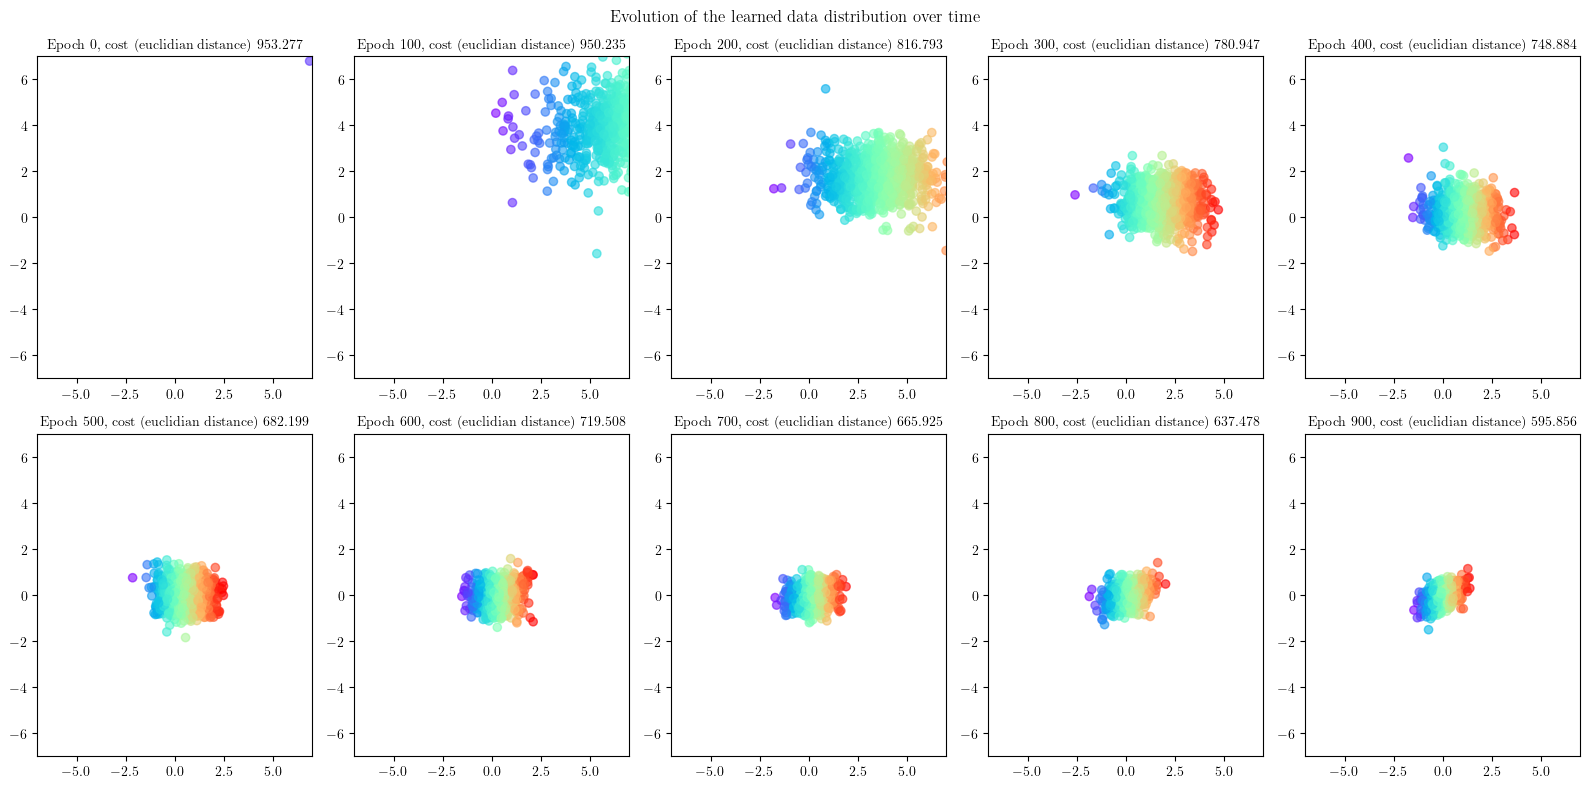

In [11]:
# Plot transformed samples at different epochs in a grid layout
nbr_lines = epochs // 500 # i specifically work on 5 columns plotting
fig, axes = plt.subplots(nbr_lines, 5, figsize=(16, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for i, (epoch, transformed_samples) in enumerate(transformed_samples_history.items()):
    row = i // 5 
    col = i % 5

    ax = axes[row, col]
    ax.scatter(transformed_samples[:, 0], transformed_samples[:, 1], 
               c=transformed_samples[:, 0], cmap="rainbow", alpha=0.6)
    ax.set_xlim(-7, 7)
    ax.set_ylim(-7, 7)
    ax.set_title(f"Epoch {epoch}, cost (euclidian distance) {np.round(stored_costs[i], 3)}", fontsize=10)

plt.suptitle("Evolution of the learned data distribution over time")

plt.tight_layout()
plt.show()

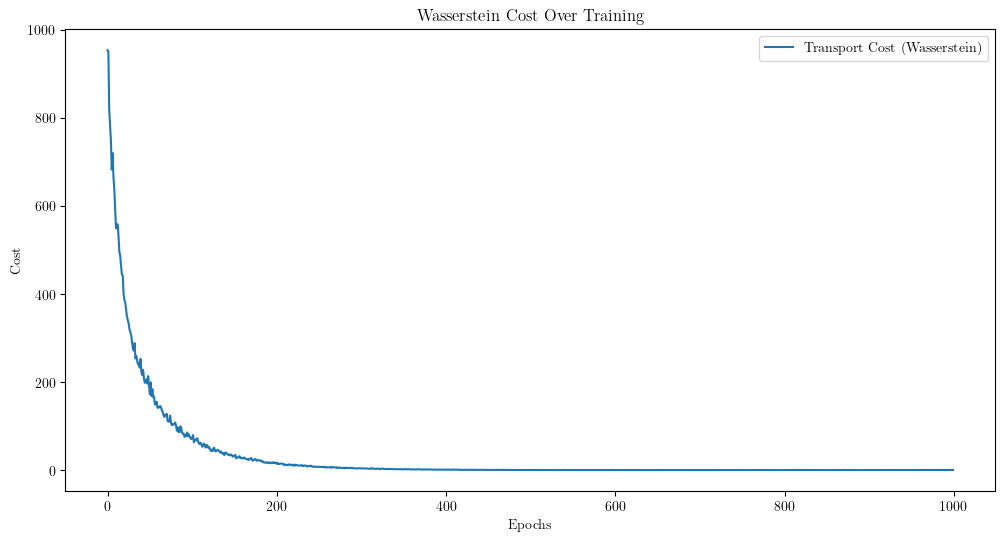

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(costs_theorical)), costs_theorical, label="Transport Cost (Wasserstein)")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Wasserstein Cost Over Training")
plt.legend()
plt.show()